# Baseline cho bài toán TGS Salt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../code') # chuyển đến thư mục chứa code để import các module
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# Import Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from torch import nn, optim

from data import TGSSaltDataset
from data.transforms import TGSTransform
from data.functional import collate_mask_fn
from data.transforms import TGSTransform, HShear
import albumentations as A

from utils.metrics import cal_mAP, cal_mIoU
from utils.viz import plot_mask_on_img, plot_training_samples

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Augmentation

Ta sẽ sử dụng albumentations làm thư viện chính cho augmentation. Các phép augmentation được sử dụng bao gồm:
* Horizontal flip
* Horizontal sheer
* Random Crop
* Random Rotate
* RandomBrightnessContrast

In [4]:
root_ds = '../dataset'
train_df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id').reset_index()
nonaug_ds = TGSSaltDataset(root_ds, train_df, transforms=None)

In [5]:
# Danh sách phép augmentation được sử dụng
augs_options = {
    'Original': A.NoOp(),
    'HFlip':A.HorizontalFlip(p=1.0),
    'HShear':HShear((0.19, 0.2), p=1.0),
    'RandomResizedCrop':A.RandomResizedCrop(width=101, height=101, p=1.0),
    'RandomRotate':A.Rotate(limit=(14, 15), p=1.0),
    'RandomBrightnessContrast':A.RandomBrightnessContrast(brightness_limit=0.1, p=1.0),
}

Plot ví dụ áp dụng các phép augmentation


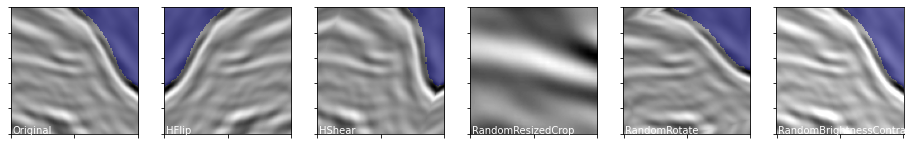

In [6]:
print("Plot ví dụ áp dụng các phép augmentation")
img, mask = nonaug_ds[3]
img = np.array(img)
mask = np.array(mask)
aug_images = []
aug_masks = []
aug_names = []
for k, tran in augs_options.items():
    aug = tran(image=img, mask=mask)
    aug_images.append(aug['image'])
    aug_masks.append(aug['mask'])
    aug_names.append(k)
plot_training_samples(imgs=aug_images, masks=aug_masks, mask_over_image=True, bl_texts=aug_names)

# Prepair data

In [7]:
cross_validation = True
fold_val_idx = 0

In [8]:
# DataFrame chứa toàn bộ train_id và đã được chia fold
df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
total_sample = len(df.index)
print('Total numper of sample:', total_sample)

train_df = df.loc[df.fold != 0].reset_index()
val_df = df.loc[df.fold == 0].reset_index()

Total numper of sample: 4000


In [9]:
# Tạo dataset tương ứng với tập được chia
train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True, resize_pad=True))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False, resize_pad=True)) # Không augmentation cho valid set
print(len(train_ds), len(val_ds))

3190 810


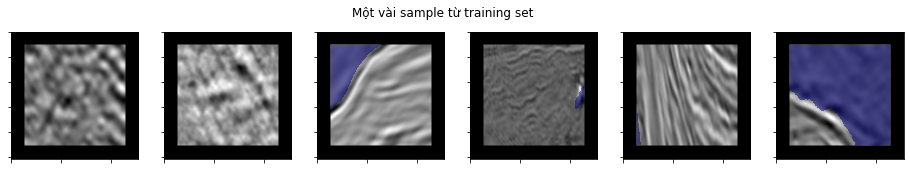

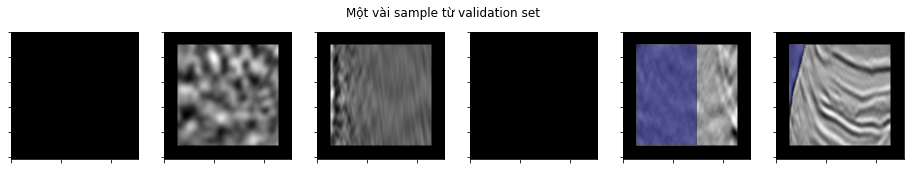

In [10]:
num_sample = 6
train_samples = [train_ds[i] for i in range(num_sample)]
val_samples = [val_ds[i] for i in range(num_sample)]
plot_training_samples(*list(zip(*train_samples)), mask_over_image=True, subtitle='Một vài sample từ training set')
plot_training_samples(*list(zip(*val_samples)), mask_over_image=True, subtitle='Một vài sample từ validation set')

In [11]:
# Chuẩn bị dataloader
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

# Define Network

<img src="../../images/unet_arch.png">

1. Sử dụng kiến trúc UNet cơ bản cho baseline model
    * Up sample bằng bilinear
    * Giảm số lượng filter đi 4 lần sau khi quan sát thấy không làm giảm kết quả

# Trainging and Validation

In [12]:
from model.unet import DoubleConv, Down, Up, OutConv

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, num_filter1, num_down_stage, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, num_filter1)
        self.downs = [Down(num_filter1 * 2**i, num_filter1 * 2**(i + 1)) for i in range(num_down_stage - 1)]
        factor = 2 if bilinear else 1 # do bilinear khong half num feature
        self.downs.append(Down(num_filter1 * 2**(num_down_stage - 1), num_filter1 * 2**num_down_stage // factor))
        self.downs = nn.Sequential(*self.downs)

        self.ups = [Up(num_filter1 * 2**(num_down_stage - i) , num_filter1 * 2**(num_down_stage -1 - i) // factor, bilinear) for i in range(num_down_stage - 1)]
        self.ups.append(Up(num_filter1 * 2 , num_filter1 , bilinear))
        self.ups = nn.Sequential(*self.ups)
        self.outc = OutConv(num_filter1, n_classes)

    def forward(self, x):
        # Contrating path
        feature_blocks = [self.inc(x)]
        for down_module in self.downs:
            feature_blocks.append(down_module(feature_blocks[-1]))

        # Upsampling path
        resample_block = feature_blocks[-1]
        for i, up_module in enumerate(self.ups):
            resample_block = up_module(resample_block, feature_blocks[-i-2])
        
        # Segment
        logits = self.outc(resample_block)
        return logits

## Training Pipeline
1. Loss function: Pixel-wise BCE Loss + Dice Loss
2. Adam optimizer (lr=3e-4), 50 epoch

In [14]:
from utils.metrics import cal_mAP
from torch.nn import functional as F
from model.layer import DiceBCELoss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
# Instantiate our model
model = UNet(1, 1, 16, 4)
model.to(device)
# Define our loss function
criterion = DiceBCELoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0003)

epochs = 50
steps = 0
print_every = 50
train_losses, test_losses = [], []

In [16]:
def train_one_epoch(train_dl, model, criterion, optimizer):
    running_loss = 0
    model.train()
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        
        # Make predictions
        log_ps = model(images)
        
        bs = images.size(0)
        loss = criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_dl)

def val_one_epoch(val_dl, model, criterion):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            bs = images.size(0)
            test_loss += criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))

            mAP = cal_mAP(log_ps.detach(), labels.detach())
            accuracy += mAP
    return test_loss / len(val_dl), accuracy / len(val_dl)

In [17]:
for e in range(epochs):
    train_epoch_loss = train_one_epoch(train_dl, model, criterion, optimizer)
    # Turn off gradients for validation
    valid_loss, acc = val_one_epoch(val_dl, model, criterion)
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_epoch_loss),
          "Valid Loss: {:.3f}.. ".format(valid_loss),
          "Valid Accuracy: {:.3f}".format(acc))

Epoch: 1/50..  Training Loss: 1.144..  Valid Loss: 0.972..  Valid Accuracy: 0.558
Epoch: 2/50..  Training Loss: 0.946..  Valid Loss: 0.798..  Valid Accuracy: 0.521
Epoch: 3/50..  Training Loss: 0.784..  Valid Loss: 0.636..  Valid Accuracy: 0.609
Epoch: 4/50..  Training Loss: 0.688..  Valid Loss: 0.567..  Valid Accuracy: 0.430
Epoch: 5/50..  Training Loss: 0.600..  Valid Loss: 0.638..  Valid Accuracy: 0.515
Epoch: 6/50..  Training Loss: 0.561..  Valid Loss: 0.446..  Valid Accuracy: 0.557
Epoch: 7/50..  Training Loss: 0.530..  Valid Loss: 0.475..  Valid Accuracy: 0.535
Epoch: 8/50..  Training Loss: 0.481..  Valid Loss: 0.371..  Valid Accuracy: 0.632
Epoch: 9/50..  Training Loss: 0.474..  Valid Loss: 0.461..  Valid Accuracy: 0.610
Epoch: 10/50..  Training Loss: 0.443..  Valid Loss: 0.344..  Valid Accuracy: 0.618
Epoch: 11/50..  Training Loss: 0.438..  Valid Loss: 0.536..  Valid Accuracy: 0.509
Epoch: 12/50..  Training Loss: 0.414..  Valid Loss: 0.311..  Valid Accuracy: 0.641
Epoch: 13/50.

Traceback (most recent call last):
Traceback (most recent call last):
  File "/python/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/python/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/python/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/python/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/python/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/python/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/python/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/python/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n

KeyboardInterrupt: 

In [ ]:
!mkdir -p ../params/baseline
torch.save(model.state_dict(), '../params/baseline/fold_{:02d}.pth'.format(fold_val_idx))

# Evaluation

In [ ]:
from utils import rle_encode
import cv2
import time
from torchvision.transforms.functional import resize

In [ ]:
#Load trained model
model = UNet(1, 1, 16, 4)
model.load_state_dict(torch.load('../params/baseline/fold_00.pth'))

In [ ]:
def test_step(model, images):
    images = images.cuda()
    logit_null = model(images)
    preds_null = torch.sigmoid(logit_null).squeeze(1).detach()
    logit_flip = model(images.flip(-1))
    preds_flip = torch.sigmoid(logit_flip).squeeze(1).flip(-1).detach()
    return (preds_flip + preds_null) / 2

In [ ]:
# Chuẩn bị test dataloader
depths_df = pd.read_csv(os.path.join(root_ds, "depths.csv"), index_col="id")
train_df = pd.read_csv(os.path.join(root_ds, "train.csv"), index_col="id", usecols=[0]) # bỏ cột rle_mask
test_df = depths_df[~depths_df.index.isin(train_df.index)].reset_index()

ds_test = TGSSaltDataset(root_ds, test_df, image_set='test', transforms=TGSTransform(augment=False))
test_dl = DataLoader(ds_test,
                          shuffle=False,
                          batch_size=32,
                          num_workers=4,
                          pin_memory=True)

In [ ]:
preds_test_upsampled = []
model.eval()
model.cuda()
with torch.no_grad():
    for images in test_dl:
        pred_masks = test_step(model, images)
        preds_test_upsampled.append(pred_masks)
preds_test = torch.cat(preds_test_upsampled, dim=0).unsqueeze(1)

In [ ]:
# Resize prediction về kích thước 101x101
preds_101 = torch.zeros(preds_test.shape[0], 101, 101)
for idx in range(preds_test.shape[0]):
    preds_101[idx] = resize(preds_test[idx], (101, 101))
print(preds_101.shape)
preds_101 = preds_101.cpu().numpy().round().astype(int)

In [ ]:
# Plot một số prediction
num_sample = 10
fig, axs = plt.subplots(1, num_sample, figsize=(5 * num_sample, 5))
for i in range(num_sample):
    offset = 100
    img = resize(ds_test[i + offset], (101, 101)).squeeze()
    mask = preds_101[i + offset]
    plot_mask_on_img(axs[i], img, mask)

In [ ]:
# Encode prediction để submit 
t1 = time.time()
pred_dict = {idx: rle_encode(preds_101[i]) for i, idx in enumerate(ds_test.image_ids)}
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

In [ ]:
# Tạo submission Dataframe
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns =['rle_mask']

In [ ]:
sub.head()

In [ ]:
# Lưu file submission
sub.to_csv('submission.csv')